In [2]:
from datetime import datetime

import pandas as pd
import numpy as np

In [3]:
pd.set_option("display.max_columns", 100)

## Preprocessing

In [4]:
train = pd.read_csv('train_final.csv')
# test = pd.read_csv('test_final.csv')

In [6]:
train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,44638.000000,44638.000000,44638.00000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000
mean,0.297594,99.395291,2016.15675,27.095166,15.778328,0.931516,2.507303,1.852883,0.102424,0.008289,0.034052,0.069672,0.140799,0.238026,2.149133,101.624687,0.067723,0.603253
std,0.457205,104.485734,0.70504,13.654692,8.807604,1.002021,1.928111,0.578898,0.393273,0.091649,0.181364,0.726281,1.540109,0.682989,17.134385,48.429930,0.255077,0.803659
min,0.000000,0.000000,2015.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,2016.00000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.380000,0.000000,0.000000
50%,0.000000,65.000000,2016.00000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000,0.000000,0.000000
75%,1.000000,154.000000,2017.00000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.00000,53.000000,31.000000,16.000000,40.000000,55.000000,3.000000,2.000000,1.000000,26.000000,72.000000,21.000000,391.000000,510.000000,8.000000,5.000000


In [7]:
from sklearn.preprocessing import LabelEncoder


def preprocess_data(df):
    # Сумма ночевок
    df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    # Проживание длительностью > 7 ночей
    df['long_stay_flag'] = (df['total_nights'] > 7).astype(int)
    # Общее кол-во гостей
    df['total_guests'] = df[['adults', 'children', 'babies']].sum(axis=1)
    # Плотность проживания
    df['guests_per_night'] = df.apply(lambda x: x.total_guests / x.total_nights if x.total_nights > 0 else 0, axis=1)
    # Кол-во запросов на гостя
    df['special_requests_per_guest'] = df.apply(lambda x: x.total_of_special_requests / x.total_guests if x.total_guests > 0 else 0, axis=1)
    # Имеется ли special_request
    df['has_special_request'] = (df['total_of_special_requests'] > 0).astype(int)

    le = LabelEncoder()
    df["country_encoded"] = le.fit_transform(df["country"])

    df["non_refund"] = (df["deposit_type"] == "Non Refund").astype(int)
    df["reservation_match"] = (df["reserved_room_type"] == df["assigned_room_type"]).astype(int)
    df["is_resort"] = (df["hotel"] == "Resort Hotel").astype(int)
    df["arrival_date_month"] = df["arrival_date_month"].apply(lambda m: datetime.strptime(m, "%B").month)

    meal_mapping = {
        "Undefined": 0,
        "SC": 0,
        "BB": 1,
        "HB": 2,
        "FB": 3
    }
    df["meal_encoded"] = df["meal"].apply(lambda x: meal_mapping[x])


    features_to_encode = ["market_segment", "customer_type", "distribution_channel"]
    feature_to_drop = ["hotel", "arrival_date_week_number", "arrival_date_day_of_month",
                      "reserved_room_type", "assigned_room_type", "meal", "country",
                      "market_segment", "distribution_channel", "deposit_type",
                      "customer_type", "reservation_status_date"]


    def encode_labels_by_cancel_ratio(df_, feature):
        cats = df_.groupby(feature)["is_canceled"].mean().sort_values().index.tolist()
        mapping = dict(zip(cats, list(range(len(cats)))))
        return df_[feature].apply(lambda x: mapping[x])

    for feature in features_to_encode:
        df[feature + "_encoded"] = encode_labels_by_cancel_ratio(df, feature)

    df = df.drop(columns=feature_to_drop)
    return df

train = preprocess_data(train)

In [8]:
train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,long_stay_flag,total_guests,guests_per_night,special_requests_per_guest,has_special_request,country_encoded,non_refund,reservation_match,is_resort,meal_encoded,market_segment_encoded,customer_type_encoded,distribution_channel_encoded
0,0,3,2016,2,0,2,2,0.0,0,0,0,0,0,0,81.0,1,0,2,0,2.0,1.000000,0.00,0,121,0,0,1,1,1,3,0
1,1,50,2016,11,1,2,2,0.0,0,0,0,0,0,0,93.6,0,2,3,0,2.0,0.666667,1.00,1,12,0,1,0,1,5,3,3
2,0,14,2015,9,1,5,2,2.0,0,0,0,0,0,0,166.0,0,3,6,0,4.0,0.666667,0.75,1,71,0,1,0,1,5,2,3
3,0,18,2015,12,2,0,2,0.0,0,0,0,0,0,0,107.0,0,0,2,0,2.0,1.000000,0.00,0,46,0,1,0,1,5,3,3
4,1,263,2016,9,2,4,2,0.0,0,0,0,0,0,0,100.3,0,0,6,0,2.0,0.333333,0.00,0,38,0,1,0,1,5,3,3


In [9]:
X = train.drop(columns=["is_canceled"])
y = train["is_canceled"]

In [10]:
from sklearn.model_selection import train_test_split


RANDOM_SEED = 47

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Scores

In [11]:
from sklearn import metrics


def score_model(true_labels, preds):
    print(f'Accuracy: {metrics.accuracy_score(true_labels, preds)}')
    print(f'Precision: {metrics.precision_score(true_labels, preds)}')
    print(f'Recall: {metrics.recall_score(true_labels, preds)}')
    print(f'F1: {metrics.f1_score(true_labels, preds)}')
    print(f'ROC-AUC: {metrics.roc_auc_score(true_labels, preds)}')

## Baseline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


pipe = Pipeline([
    ('logit', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

score_model(y_valid, pipe.fit(X_train, y_train).predict(X_valid))

Accuracy: 0.8234767025089605
Precision: 0.7976318622174381
Recall: 0.5525727069351231
F1: 0.652863436123348
ROC-AUC: 0.7461870899389031


/robodelivery/jupyterhub/kernels/vanilla_python/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
pipe_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

score_model(y_valid, pipe_scaler.fit(X_train, y_train).predict(X_valid))

Accuracy: 0.8269489247311828
Precision: 0.8235628912919749
Recall: 0.5395227442207308
F1: 0.6519486370804235
ROC-AUC: 0.74494548994578


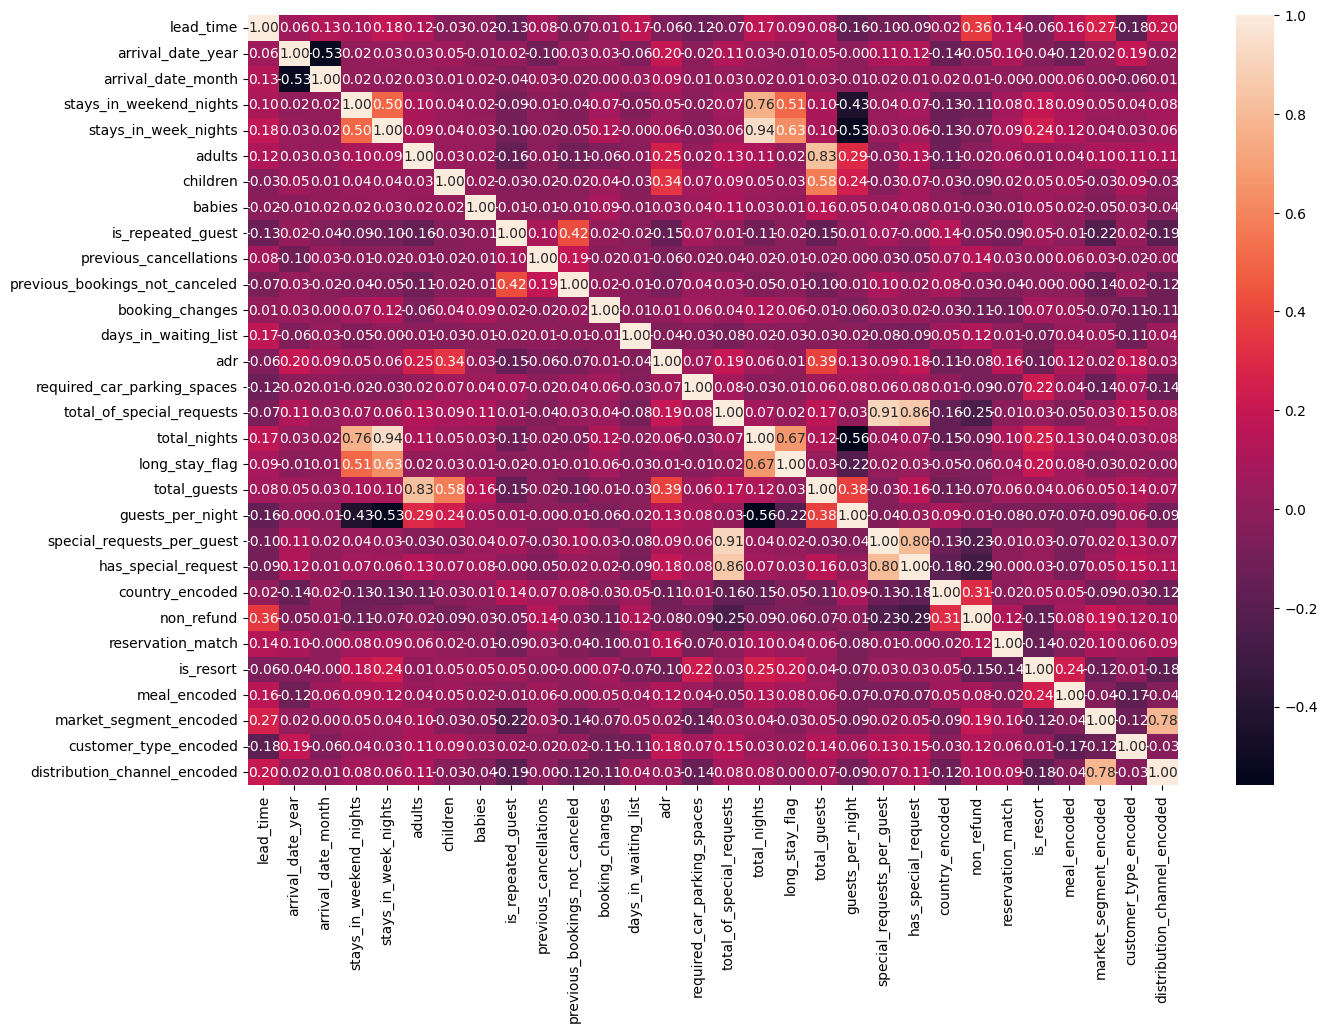

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f")
plt.show()

Признаки слабо скоррелированы, поэтому применение PCA не поможет улучшить качество модели

In [15]:
pipe_scaler_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('logit', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

score_model(y_valid, pipe_scaler_pca.fit(X_train, y_train).predict(X_valid))

Accuracy: 0.8137320788530465
Precision: 0.8056388722255549
Recall: 0.5007457121551081
F1: 0.6176132444240056
ROC-AUC: 0.7244362566539229


## Catboost

In [16]:
from catboost import CatBoostClassifier


catboost_classifier = CatBoostClassifier(iterations=15, random_seed=RANDOM_SEED, verbose=0)
catboost_classifier.fit(X_train, y_train)
catboost_preds = catboost_classifier.predict(X_valid)

score_model(y_valid, catboost_preds)

Accuracy: 0.8635752688172043
Precision: 0.8401486988847584
Recall: 0.674123788217748
F1: 0.7480347538270583
ROC-AUC: 0.809524270029463


In [34]:
pd.DataFrame.from_dict(
    dict(zip(catboost_classifier.feature_names_, catboost_classifier.feature_importances_)).items()
).sort_values(1, ascending=False)

,0,1
23,non_refund,27.330745
22,country_encoded,13.694988
14,required_car_parking_spaces,11.993818
27,market_segment_encoded,6.982421
28,customer_type_encoded,6.489562
9,previous_cancellations,5.763394
0,lead_time,5.403405
1,arrival_date_year,5.314898
24,reservation_match,5.203273
15,total_of_special_requests,3.449944


## Grid search

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


catboost_classifier = CatBoostClassifier(random_seed=RANDOM_SEED)

param_grid = {
    'iterations': [30, 60, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'depth': [4, 6, 8],
    # 'l2_leaf_reg': [1, 3, 5],
    # 'border_count': [32, 64, 128]
}

scoring = {
    'F1': metrics.make_scorer(metrics.f1_score),
    'AUC': metrics.make_scorer(metrics.roc_auc_score)
}

grid_search = GridSearchCV(
    estimator=catboost_classifier,
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший AUC score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

test_accuracy = metrics.accuracy_score(y_valid, y_pred)
test_auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

0:	learn: 0.6046438	total: 14.8ms	remaining: 1.47s
1:	learn: 0.5530597	total: 21ms	remaining: 1.03s
2:	learn: 0.5157810	total: 26.7ms	remaining: 863ms
3:	learn: 0.4747929	total: 32ms	remaining: 768ms
4:	learn: 0.4452012	total: 38.3ms	remaining: 727ms
5:	learn: 0.4257340	total: 43.9ms	remaining: 688ms
6:	learn: 0.4140349	total: 49.3ms	remaining: 655ms
7:	learn: 0.3989689	total: 54.7ms	remaining: 629ms
8:	learn: 0.3868414	total: 63.7ms	remaining: 644ms
9:	learn: 0.3795704	total: 69.5ms	remaining: 625ms
10:	learn: 0.3713089	total: 75.6ms	remaining: 612ms
11:	learn: 0.3637582	total: 89.6ms	remaining: 657ms
12:	learn: 0.3597776	total: 101ms	remaining: 675ms
13:	learn: 0.3558521	total: 109ms	remaining: 667ms
14:	learn: 0.3515848	total: 120ms	remaining: 682ms
15:	learn: 0.3479413	total: 134ms	remaining: 703ms
16:	learn: 0.3445418	total: 142ms	remaining: 694ms
17:	learn: 0.3419841	total: 149ms	remaining: 679ms
18:	learn: 0.3399808	total: 154ms	remaining: 658ms
19:	learn: 0.3380569	total: 160ms